# NURBS - Freeform telescope

Author: Matteo Taccola

Example of telescope definition based on NURBS freeform surfaces and first optimization

In [1]:
import numpy as np
from optiland import optic, analysis, optimization

In [2]:
from optiland.geometries import NurbsGeometry
from optiland.coordinate_system import CoordinateSystem
from optiland.materials import IdealMaterial, Material
from optiland.surfaces import Surface

First optical parameters derived from the optimization of an obstructed telescope

In [3]:
radius1 = 99.7616
radius2 = 300.247
radius3 = -220.462
conic1 = 3.15161e-06
conic2 = -1.27041e-05
conic3 = -3.57947e-05

In [4]:
field_max = 2

Distances between optical elements

In [5]:
d12 = 100.0
d23 = 100.0
d3f = 110.0

Mirrors and focal plane tilts

In [6]:
rx1 = np.radians(22.5)
drx2 = np.radians(22.5)
drx3 = np.radians(22.5)
rx4 = np.radians(-45)

Dimensions to perform fitting of conic surfaces with NURBS

In [7]:
norm_x_1 = 10.
norm_y_1 = 10.
norm_x_2 = 30.
norm_y_2 = 30.
norm_x_3 = 30.
norm_y_3 = 30.

In [8]:
nurbs_tel = optic.Optic()

In [9]:
material_pre = IdealMaterial(n=1.0)  # air
material_post = IdealMaterial(n=1.0)

In [10]:
cs1 = CoordinateSystem(x=0, y=0, z=0, rx=rx1, ry=0, rz=0, reference_cs=None)
y2 = d12*np.sin(2.0*rx1)
z2 = -d12*np.cos(2.0*rx1)
rx2 = 2.0*rx1 + drx2
cs2 = CoordinateSystem(x=0, y=y2, z=z2, rx=rx2, ry=0, rz=0, reference_cs=None)
y3 = y2-d23*np.sin(2.0*(drx2+rx1))
z3 = z2+d23*np.cos(2.0*(drx2+rx1))
rx3 = 2.0*rx1 + 2.0*drx2 + drx3
cs3 = CoordinateSystem(x=0, y=y3, z=z3, rx=rx3, ry=0, rz=0, reference_cs=None)
y4 = y3 + d3f*np.sin(2.0*rx1)
z4 = z3 + d3f*np.cos(2.0*rx1)

In [11]:
# if control points are passed radius and conic are ignored. The surface is built as NURBS from control points and weights 
nurbs_geo1 = NurbsGeometry(
    coordinate_system=cs1,
    radius = radius1,
    conic=conic1,
    nurbs_norm_x = norm_x_1,
    nurbs_norm_y = norm_y_1,
)       
nurbs_geo1.fit_surface()
nurbs_geo2 = NurbsGeometry(
    coordinate_system=cs2,
    radius = radius2,
    conic=conic2,
    nurbs_norm_x = norm_x_2,
    nurbs_norm_y = norm_y_2,    
) 
nurbs_geo2.fit_surface()
nurbs_geo3 = NurbsGeometry(
    coordinate_system=cs3,
    radius = radius3,
    conic=conic3,
    nurbs_norm_x = norm_x_3,
    nurbs_norm_y = norm_y_3,
)        
nurbs_geo3.fit_surface()

In [12]:
new_surface1 = Surface(
    geometry=nurbs_geo1,
    material_pre=material_pre,
    material_post=material_post,
    is_stop = True
)
new_surface2 = Surface(
    geometry=nurbs_geo2,
    material_pre=material_pre,
    material_post=material_post,
)
new_surface3 = Surface(
    geometry=nurbs_geo3,
    material_pre=material_pre,
    material_post=material_post,
)

# Set interaction model to reflective for all surfaces
new_surface1.interaction_model.is_reflective = True
new_surface2.interaction_model.is_reflective = True
new_surface3.interaction_model.is_reflective = True

In [13]:
# add surfaces
nurbs_tel.add_surface(index=0, radius=np.inf, thickness=np.inf)
nurbs_tel.add_surface(
    index=1,
    new_surface=new_surface1,
)
nurbs_tel.add_surface(
    index=2,
    new_surface=new_surface2,
)
nurbs_tel.add_surface(
    index=3,
    new_surface=new_surface3,
)
nurbs_tel.add_surface(index=4, y=y4, z=z4, rx=rx4)

In [14]:
nurbs_tel.set_aperture(aperture_type='imageFNO', value=5)

In [15]:
# add field
field_max = 2.
nurbs_tel.set_field_type(field_type="angle")
nurbs_tel.add_field(y=0)
nurbs_tel.add_field(y=field_max)
nurbs_tel.add_field(x=-field_max, y=0)
nurbs_tel.add_field(x=field_max, y=0)

# add wavelength
wave = 0.55
nurbs_tel.add_wavelength(value=wave, is_primary=True)

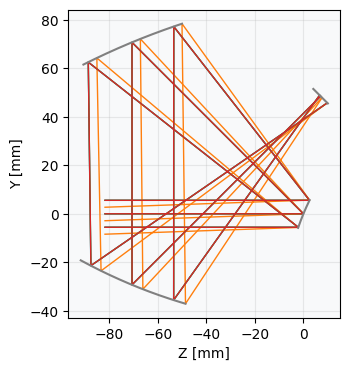

In [16]:
_ = nurbs_tel.draw()

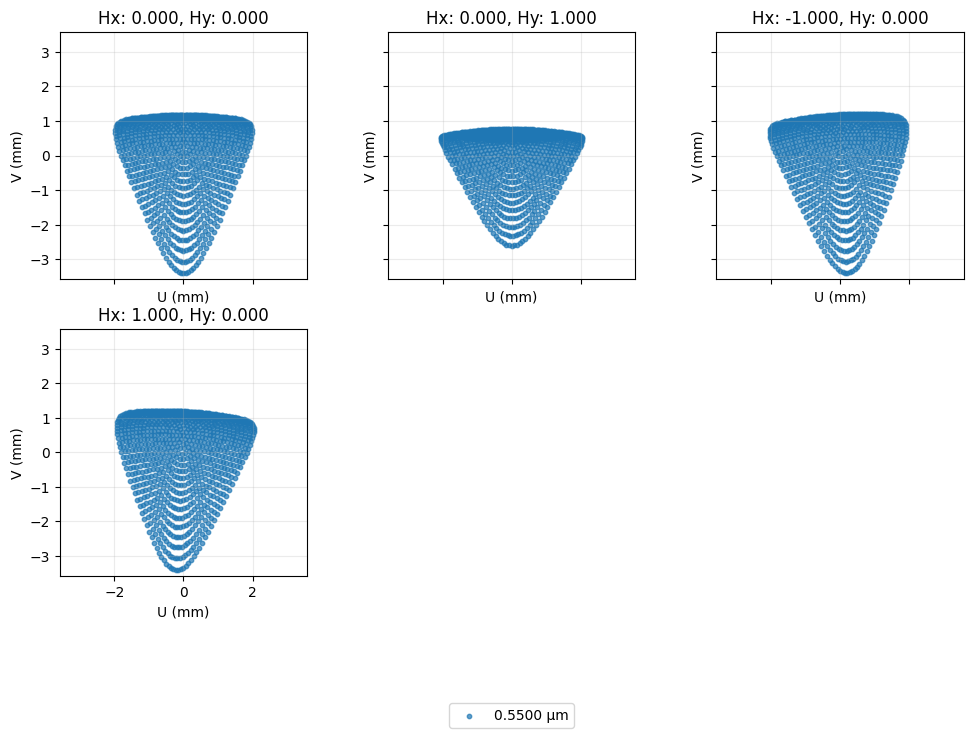

In [17]:
spot = analysis.SpotDiagram(nurbs_tel,num_rings=18)
_ = spot.view()

Telescope has severe aberrations due to tilts of the optical elements

In [18]:
n_control_points_u = nurbs_geo1.P_size_u
n_control_points_v = nurbs_geo1.P_size_v

First optimization trial.
The variables are the positions and weigths of the control points and position/tilt of the focal plane

In [19]:
problem = optimization.OptimizationProblem()

for field in nurbs_tel.fields.get_field_coords():
    input_data = {
        "optic": nurbs_tel,
        "surface_number": -1,
        "Hx": field[0],
        "Hy": field[1],
        "num_rays": 16,
        "wavelength": wave,
        "distribution": "uniform",
    }
    problem.add_operand(
        operand_type="rms_spot_size",
        target=0,
        weight=1,
        input_data=input_data,
    )
#variables are the coordinates and weights of the control points 
for i in range(3):
    for j in range(n_control_points_u):
        for k in range(n_control_points_v):
            problem.add_variable(nurbs_tel, "nurbs_control_point", surface_number=1, coeff_index = [i,j,k], min_val=-100, max_val=100)
            problem.add_variable(nurbs_tel, "nurbs_control_point", surface_number=2, coeff_index = [i,j,k], min_val=-100, max_val=100)
            problem.add_variable(nurbs_tel, "nurbs_control_point", surface_number=3, coeff_index = [i,j,k], min_val=-100, max_val=100)

for j in range(n_control_points_u):
    for k in range(n_control_points_v):
        problem.add_variable(nurbs_tel, "nurbs_weight", surface_number=1, coeff_index = [j,k], min_val=0, max_val=10)
        problem.add_variable(nurbs_tel, "nurbs_weight", surface_number=2, coeff_index = [j,k], min_val=0, max_val=10)
        problem.add_variable(nurbs_tel, "nurbs_weight", surface_number=3, coeff_index = [j,k], min_val=0, max_val=10)

problem.add_variable(
    nurbs_tel,
    "decenter",
    axis="y",
    surface_number=4,
    min_val=y4-5.,
    max_val=y4+5.,
)
problem.add_variable(
    nurbs_tel,
    "decenter",
    axis="z",
    surface_number=4,
    min_val=z4-5.,
    max_val=z4+5.,
)

# tilts
problem.add_variable(
    nurbs_tel,
    "tilt",
    axis="x",
    surface_number=4,
    min_val=rx4-np.radians(5.0),
    max_val=rx4+np.radians(5.0),
)

In [20]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                5.77534 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   1.224 │   1.224 │          25.92 │
│  1 │ rms spot size  │        0 │              │              │        1 │   1.121 │   1.121 │          21.75 │
│  2 │ rms spot size  │        0 │              │              │        1 │   1.229 │   1.229 │          26.16 │
│  3 │ rms spot size  │        0 │              │             

In [ ]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize()

In [ ]:
problem.info()

In [ ]:
spot = analysis.SpotDiagram(nurbs_tel, num_rings=18)
_ = spot.view() 

In [ ]:
_ = nurbs_tel.draw()